# Evaluacion Final Intro a la Inteligencia Artificial

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 2- Pre-procesamiento del dataset

In [2]:
class Data(object):

    def __init__(self, path):
        self.dataset = self._build_dataset(path)
        self.x = None
        self.y = None
        
    @staticmethod
    def _build_dataset( path):
        structure = [('x', float),
                     ('y', float)]

        with open(path, encoding="utf8") as data_csv:
            data_gen = ((float(line.split(',')[0]), float(line.split(',')[1]))
                        for i, line in enumerate(data_csv) if i != 0)
            data = np.fromiter(data_gen, structure)
        
        return data

    def split(self, percentage):  # 0.8
        self.x = self.dataset['x']
        self.y = self.dataset['y']

        # X.shape[0] -> 10 (filas)

        permuted_idxs = np.random.permutation(self.x.shape[0])
        # 2,1,3,4,6,7,8,5,9,0

        train_idxs = permuted_idxs[0:int(percentage * self.x.shape[0])]
        # permuted_idxs[0:8]
        # [2,1,3,4,5,6,7,8,5]

        test_idxs = permuted_idxs[int(percentage * self.x.shape[0]): self.x.shape[0]]
        # [9,0]

        x_train = self.x[train_idxs]
        x_test = self.x[test_idxs]

        y_train = self.y[train_idxs]
        y_test = self.y[test_idxs]

        return x_train, x_test, y_train, y_test

In [3]:
dataset=Data(r'clase_8_dataset.csv')

In [4]:
x_train, x_test, y_train, y_test = dataset.split(0.8)

In [5]:
print(f"Dimensiones dataset: Feature: {dataset.x.shape} - Salida {dataset.y.shape}")

Dimensiones dataset: Feature: (499,) - Salida (499,)


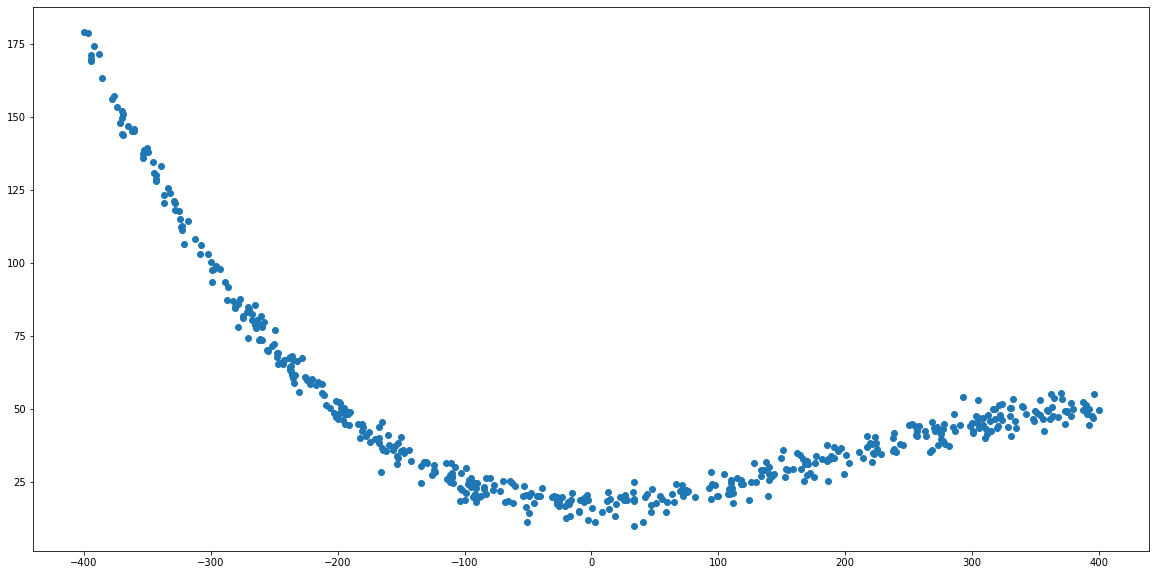

In [6]:
plt.figure(figsize=(20,10))
plt.scatter(dataset.x, dataset.y)

In [7]:
print(f"Dimensiones datos de entrenamiento: Feature: {x_train.shape} - Salida {y_train.shape}")

Dimensiones datos de entrenamiento: Feature: (399,) - Salida (399,)


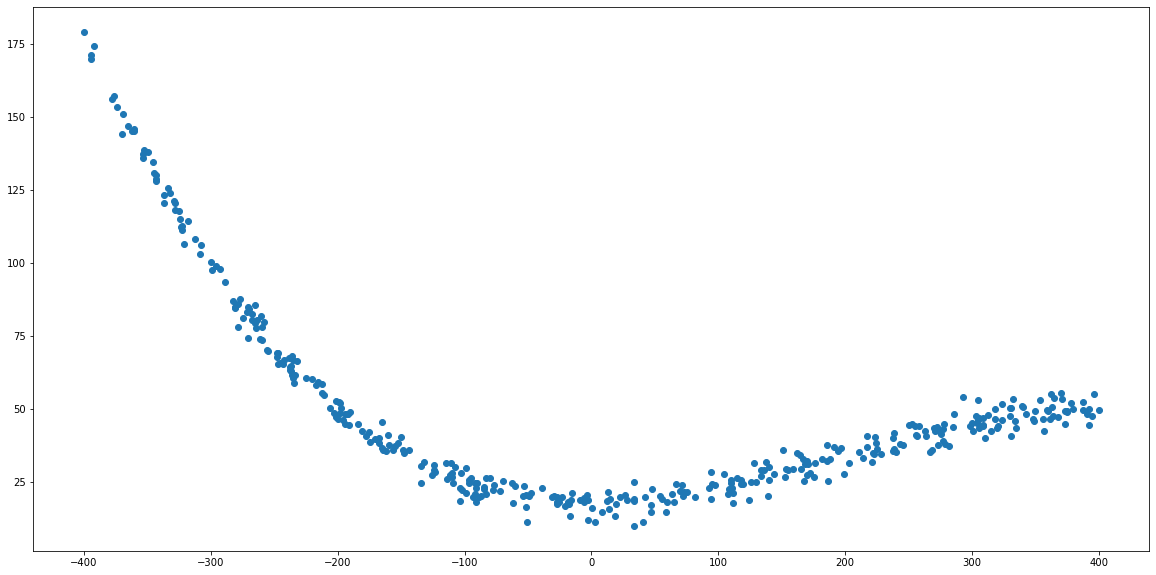

In [8]:
plt.figure(figsize=(20,10))
plt.scatter(x_train, y_train)

In [9]:
print(f"Dimensiones datos de entrenamiento: Feature: {x_test.shape} - Salida {y_test.shape}")

Dimensiones datos de entrenamiento: Feature: (100,) - Salida (100,)


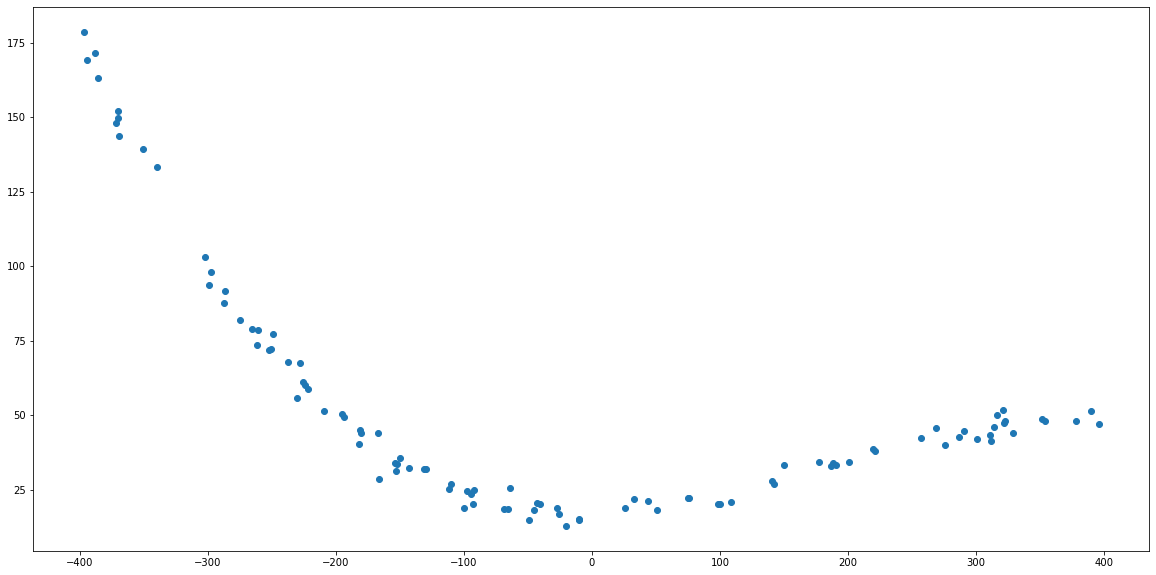

In [10]:
plt.figure(figsize=(20,10))
plt.scatter(x_test, y_test)

## 3- Regresion Polinomica

In [11]:
def mse(target, prediction):
    return np.sum((target - prediction) ** 2) / target.size

In [12]:
class BaseModel(object):

    def __init__(self):
        self.model = None
        self.predicted = None

    def fit(self, x, y):
        return NotImplemented

    def predict(self, x):
        return NotImplemented
    
class LinearRegression(BaseModel):

    def fit(self, x_train, y_train):
        if len(x_train.shape) == 1:
            w = x_train.T.dot(y_train) / x_train.T.dot(x_train)
        else:
            # w = ((x_train.T*x_train)^-1)*x_train.T*y_train
            w = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        self.model = w

    def predict(self, x):
        self.predicted = np.sum(self.model.T * x, axis=1)

    def plot_model(self, x, y):
        plt.figure()
        plt.subplot(1, 1, 1)
        plt.gca().set_title('Fitting curves')
        plt.plot(x, y, 'o')
        plt.plot(x, self.predicted, '-')

In [13]:
def k_folds(x_train, y_train, k=10):
    """
    Establece un loop para los k-folds, por defecto se definen 10.
    Devuelve media del error cuadratico obtenido en cada loop

    1ro
     ___ ___ ___       ___ ___
    | 1 | 2 | 3 |     |k-1| k |
    |Val|Tra|Tra| ... |Tra|Tra|

    2do
     ___ ___ ___       ___ ___
    | 1 | 2 | 3 |     |k-1| k |
    |Tra|Val|Tra| ... |Tra|Tra|

    k-esimo
     ___ ___ ___       ___ ___
    | 1 | 2 | 3 |     |k-1| k |
    |Tra|Tra|Tra| ... |Tra|Val|


    """

    l_regression = LinearRegression()
    j=0
    chunk_size = int(len(x_train) / k)
    mse_list = []
    w_list = np.zeros((k+1,x_train.shape[1]))
    
    for i in range(0, len(x_train), chunk_size):
        end = i + chunk_size if i + chunk_size <= len(x_train) else len(x_train)
        new_x_valid = x_train[i: end]
        new_y_valid = y_train[i: end]
        new_x_train = np.concatenate([x_train[: i], x_train[end:]])
        new_y_train = np.concatenate([y_train[: i], y_train[end:]])

        l_regression.fit(new_x_train, new_y_train)
        l_regression.predict(new_x_valid)
        mse_list.append(mse(new_y_valid, l_regression.predicted))
        
        w_list[j] = l_regression.model
        j+=1
        
        #l_regression.plot_model(new_x_train[:,0], new_y_train)
        print(f"Modelo {j}: {l_regression.model}, MSE: {mse(new_y_valid, l_regression.predicted)}")
    
    mean_mse = np.mean(mse_list)

    return mean_mse, mse_list, w_list

In [14]:
from split_dataset import dataset_manipulation

### Grado 1

In [15]:
# Expando el arreglo x_train de modo de incluir una feature de unos y asi
# agregar la ordenada al origen a mi modelo
x_expanded = np.vstack((x_train, np.ones(len(x_train)))).T
print(x_expanded[0:5])

[[-399.93809234    1.        ]
 [-345.51185861    1.        ]
 [-237.06602811    1.        ]
 [-391.97926159    1.        ]
 [ 299.62610261    1.        ]]


In [16]:
mse_n1,mse_list_n1, model_n1= k_folds(x_expanded, y_train, k=4)
n1_min_idx = np.argmin(mse_list_n1)
print()
print(f"El mejor es el modelo {n1_min_idx+1}: {model_n1[n1_min_idx,:]}, por su menor MSE: {mse_list_n1[n1_min_idx]}")

Modelo 1: [-0.06956808 46.90153817], MSE: 1215.4972135004668
Modelo 2: [-0.08805937 49.96984522], MSE: 679.5828215286939
Modelo 3: [-0.08299094 50.49879521], MSE: 673.7882593309131
Modelo 4: [-0.0731598  49.36977883], MSE: 759.9666957539617
Modelo 5: [-0.0793734  49.37242638], MSE: 1230.693687791701

El mejor es el modelo 3: [-0.08299094 50.49879521], por su menor MSE: 673.7882593309131


In [17]:
y_hat_n1 = model_n1[n1_min_idx][0] * np.power(x_test, 1) + model_n1[n1_min_idx][1]
print(f"MSE de test {mse(y_test, y_hat_n1)}")

MSE de test 1084.0839922367325


In [18]:
x_ordenado = x_train.copy()
x_ordenado = x_ordenado[np.argsort(x_ordenado)]

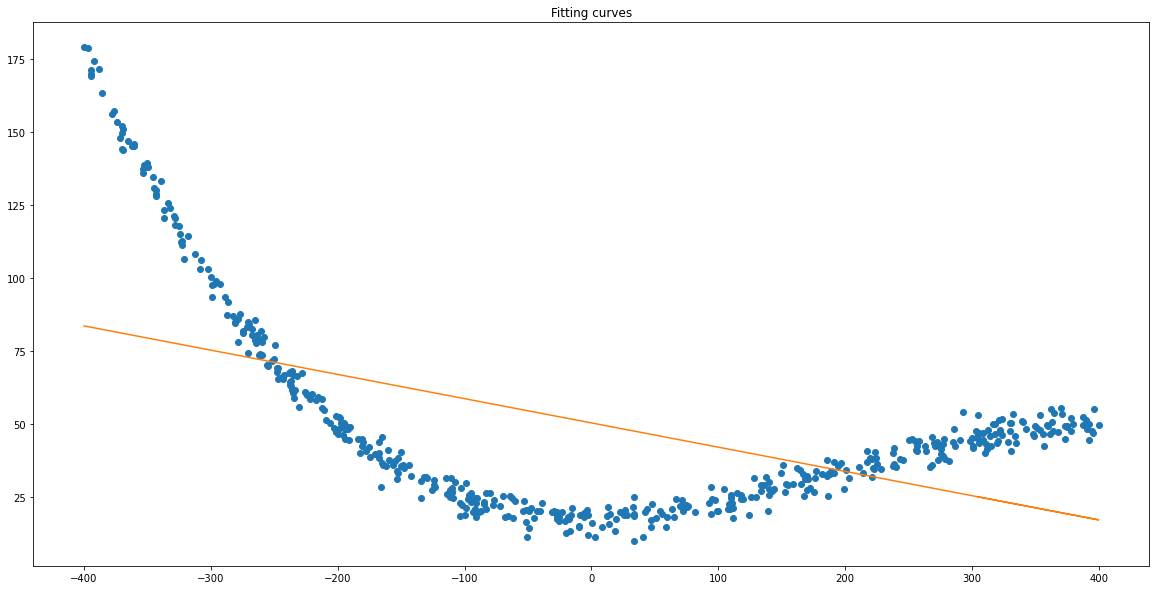

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
plt.gca().set_title('Fitting curves')
plt.plot(dataset.x, dataset.y, 'o')
plt.plot(x_train, np.sum(model_n1[n1_min_idx].T*x_expanded, axis=1), '-')

### Grado 2

In [20]:
x_n2 = dataset_manipulation(x_train, polinomy_grade=2, bias=True)

print("Regresion polinomica con grado 2")
print(x_n2[0:5])

Regresion polinomica con grado 2
[[ 1.59950478e+05 -3.99938092e+02  1.00000000e+00]
 [ 1.19378444e+05 -3.45511859e+02  1.00000000e+00]
 [ 5.62003017e+04 -2.37066028e+02  1.00000000e+00]
 [ 1.53647742e+05 -3.91979262e+02  1.00000000e+00]
 [ 8.97758014e+04  2.99626103e+02  1.00000000e+00]]


In [21]:
print("Regresion polinomica grado 2")
mse_n2,mse_list_n2, model_n2= k_folds(x_n2, y_train, k=4)
n2_min_idx = np.argmin(mse_list_n2)
print()
print(f"El mejor es el modelo {n2_min_idx+1}: {model_n2[n2_min_idx,:]}, por su menor MSE: {mse_list_n2[n2_min_idx]}")

Regresion polinomica grado 2
Modelo 1: [ 5.64450822e-04 -8.69685201e-02  1.85341107e+01], MSE: 137.26588620544274
Modelo 2: [ 5.92486910e-04 -9.32280315e-02  1.82455758e+01], MSE: 79.8870985531059
Modelo 3: [ 5.88485273e-04 -9.46545269e-02  1.76885779e+01], MSE: 85.98857503367782
Modelo 4: [ 5.87345536e-04 -9.32776543e-02  1.72434581e+01], MSE: 104.18750871658611
Modelo 5: [ 5.82362365e-04 -9.24297720e-02  1.80198825e+01], MSE: 87.30440928861744

El mejor es el modelo 2: [ 5.92486910e-04 -9.32280315e-02  1.82455758e+01], por su menor MSE: 79.8870985531059


In [22]:
y_hat_n2 = model_n2[n2_min_idx][0] * np.power(x_test, 2) + model_n2[n2_min_idx][1] * np.power(x_test, 1) + model_n2[n2_min_idx][0]
print(f"MSE de test {mse(y_test, y_hat_n2)}")

MSE de test 407.28821855109715


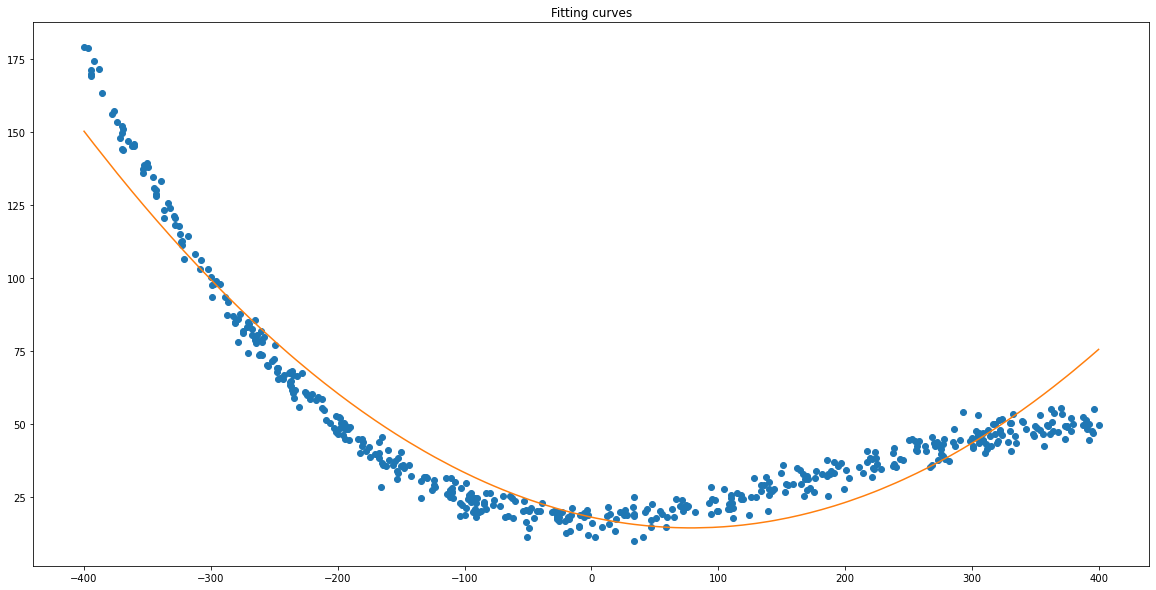

In [23]:
x2 = x_train.copy()
x2 = x2[np.argsort(x_train)]

plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
plt.gca().set_title('Fitting curves')
plt.plot(dataset.x, dataset.y, 'o')
plt.plot(x2, np.sum(model_n2[n2_min_idx].T*x_n2, axis=1)[np.argsort(x_train)], '-')


### Grado 3

In [24]:
x_n3 = dataset_manipulation(x_train, polinomy_grade=3, bias=True)
print("\nRegresion polinomica con grado 3")
print(x_n3[0:5])


Regresion polinomica con grado 3
[[-6.39702889e+07  1.59950478e+05 -3.99938092e+02  1.00000000e+00]
 [-4.12466682e+07  1.19378444e+05 -3.45511859e+02  1.00000000e+00]
 [-1.33231823e+07  5.62003017e+04 -2.37066028e+02  1.00000000e+00]
 [-6.02267283e+07  1.53647742e+05 -3.91979262e+02  1.00000000e+00]
 [ 2.68991735e+07  8.97758014e+04  2.99626103e+02  1.00000000e+00]]


In [25]:
print("Regresion polinomica grado 3")
mse_n3,mse_list_n3, model_n3= k_folds(x_n3, y_train, k=4)
n3_min_idx = np.argmin(mse_list_n3)
print()
print(f"El mejor es el modelo {n3_min_idx+1}: {model_n3[n3_min_idx,:]}, por su menor MSE: {mse_list_n3[n3_min_idx]}")

Regresion polinomica grado 3
Modelo 1: [-9.95964774e-07  5.99322341e-04 -2.31565915e-04  1.80720043e+01], MSE: 10.918660434941534
Modelo 2: [-1.01305301e-06  5.99658182e-04  1.29157386e-03  1.83250971e+01], MSE: 10.007799870789075
Modelo 3: [-1.00818823e-06  6.02327232e-04  7.18540080e-04  1.79560412e+01], MSE: 9.136965400435459
Modelo 4: [-9.90380256e-07  6.03764319e-04 -6.21813389e-04  1.78620172e+01], MSE: 7.386012512276611
Modelo 5: [-1.00076060e-06  6.00253135e-04  2.89942493e-05  1.81193130e+01], MSE: 43.193389021996616

El mejor es el modelo 4: [-9.90380256e-07  6.03764319e-04 -6.21813389e-04  1.78620172e+01], por su menor MSE: 7.386012512276611


In [26]:
y_hat_n3 = model_n3[n3_min_idx][0] * np.power(x_test, 3) + model_n3[n3_min_idx][1] * np.power(x_test, 2) + model_n3[n3_min_idx][2] * np.power(x_test, 1)+ model_n3[n3_min_idx][3]
print(f"MSE de test {mse(y_test, y_hat_n3)}")

MSE de test 9.688233619830935


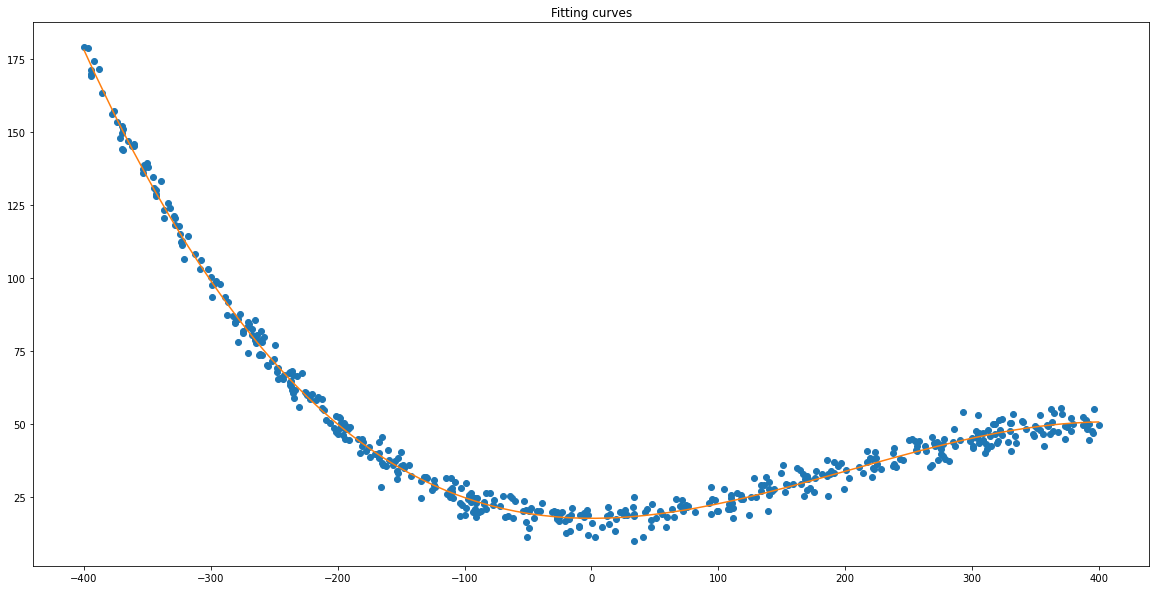

In [27]:
x3 = x_train.copy()
x3 = x3[np.argsort(x_train)]

plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
plt.gca().set_title('Fitting curves')
plt.plot(dataset.x, dataset.y, 'o')
plt.plot(x3, np.sum(model_n3[n3_min_idx].T*x_n3, axis=1)[np.argsort(x_train)], '-')

### Grado 4

In [28]:
x_n4 = dataset_manipulation(x_train, polinomy_grade=4, bias=True)
print("\nRegresion polinomica con grado 4")
print(x_n4[0:5])


Regresion polinomica con grado 4
[[ 2.55841553e+10 -6.39702889e+07  1.59950478e+05 -3.99938092e+02
   1.00000000e+00]
 [ 1.42512130e+10 -4.12466682e+07  1.19378444e+05 -3.45511859e+02
   1.00000000e+00]
 [ 3.15847391e+09 -1.33231823e+07  5.62003017e+04 -2.37066028e+02
   1.00000000e+00]
 [ 2.36076285e+10 -6.02267283e+07  1.53647742e+05 -3.91979262e+02
   1.00000000e+00]
 [ 8.05969451e+09  2.68991735e+07  8.97758014e+04  2.99626103e+02
   1.00000000e+00]]


In [29]:
print("Regresion polinomica grado 4")
mse_n4, mse_list_n4, model_n4 = k_folds(x_n4, y_train, k=4)
n4_min_idx = np.argmin(mse_list_n4)
print()
print(f"El mejor es el modelo {n4_min_idx+1}: {model_n4[n4_min_idx,:]}, por su menor MSE: {mse_list_n4[n4_min_idx]}")

Regresion polinomica grado 4
Modelo 1: [ 3.62093975e-11 -9.97338622e-07  5.94689758e-04 -1.59816362e-04
  1.81464797e+01], MSE: 10.92768084964085
Modelo 2: [-2.69724707e-11 -1.01279958e-06  6.03315793e-04  1.27790262e-03
  1.82639728e+01], MSE: 10.03480810187398
Modelo 3: [-3.37083920e-11 -1.00789586e-06  6.06892710e-04  7.16365735e-04
  1.78794599e+01], MSE: 9.176407518869732
Modelo 4: [ 2.58519896e-11 -9.90820837e-07  6.00305849e-04 -6.01212524e-04
  1.79189136e+01], MSE: 7.396140231410558
Modelo 5: [ 3.18300451e-11 -1.00126114e-06  5.95986470e-04  4.92034706e-05
  1.81906244e+01], MSE: 43.87070019813542

El mejor es el modelo 4: [ 2.58519896e-11 -9.90820837e-07  6.00305849e-04 -6.01212524e-04
  1.79189136e+01], por su menor MSE: 7.396140231410558


In [30]:
y_hat_n4 = model_n4[n4_min_idx][0] * np.power(x_test, 4) + model_n4[n4_min_idx][1] * np.power(x_test, 3) + model_n4[n4_min_idx][2] * np.power(x_test, 2)+ model_n4[n4_min_idx][3] * np.power(x_test, 1) + model_n4[n4_min_idx][4]
print(f"MSE de test {mse(y_test, y_hat_n4)}")

MSE de test 9.726219398627462


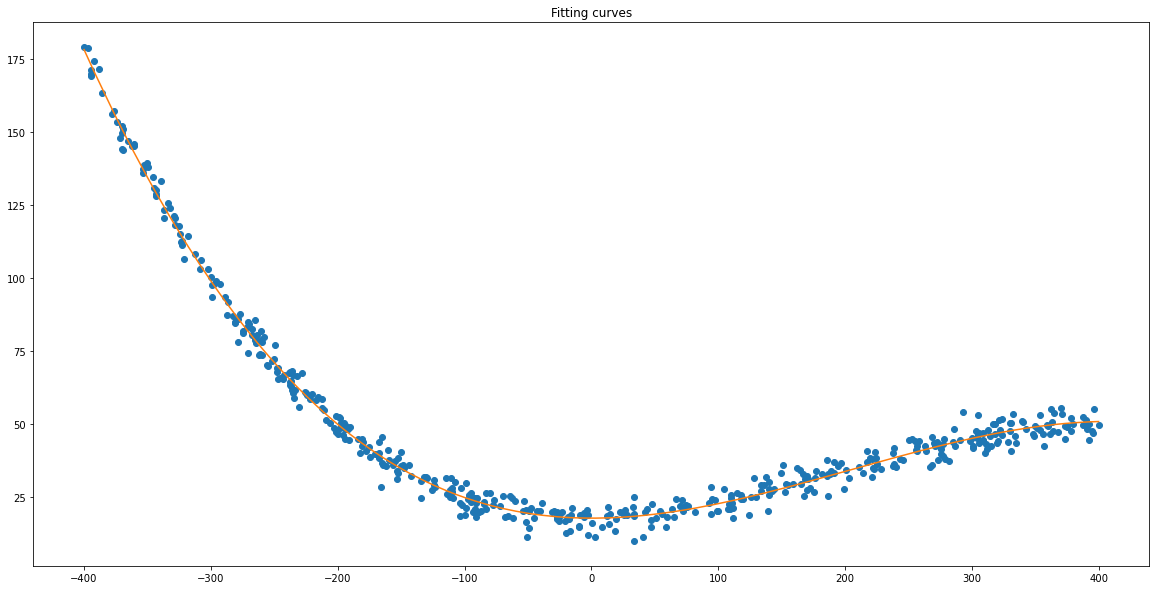

In [31]:
x4 = x_train.copy()
x4 = x4[np.argsort(x_train)]

plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
plt.gca().set_title('Fitting curves')
plt.plot(dataset.x, dataset.y, 'o')
plt.plot(x4, np.sum(model_n4[n4_min_idx].T*x_n4, axis=1)[np.argsort(x_train)], '-')

In [32]:
print("Tabla de los mejores modelos por grado de polinomio")
pd.DataFrame(data=[[np.float16(model_n1[n1_min_idx,:]), mse_list_n1[n1_min_idx], mse(y_test, y_hat_n1)],\
                   [np.float16(model_n2[n2_min_idx,:]), mse_list_n2[n2_min_idx], mse(y_test, y_hat_n2)],\
                   [np.float16(model_n3[n3_min_idx,:]), mse_list_n3[n3_min_idx], mse(y_test, y_hat_n3)],\
                   [np.float16(model_n4[n4_min_idx,:]), mse_list_n4[n4_min_idx], mse(y_test, y_hat_n4)]],\
             index=["Grado 1","Grado 2","Grado 3","Grado 4"], columns=["Modelo", "MSE_train", "MSE_test"])

Tabla de los mejores modelos por grado de polinomio


,Modelo,MSE_train,MSE_test
Grado 1,"[-0.083, 50.5]",673.788259,1084.083992
Grado 2,"[0.0005927, -0.0932, 18.25]",79.887099,407.288219
Grado 3,"[-1e-06, 0.0006037, -0.000622, 17.86]",7.386013,9.688234
Grado 4,"[0.0, -1e-06, 0.0006003, -0.0006013, 17.92]",7.396140,9.726219


**Conclusiones:** Dado los mejores modelos de cada grado de polinomio, considero que el mejor modelo es el modelo de grado 3. Ya que posee una muy leve diferencia de error con el de grado 4, pero este ultimo complejiza el modelo al agregarle una feature más.

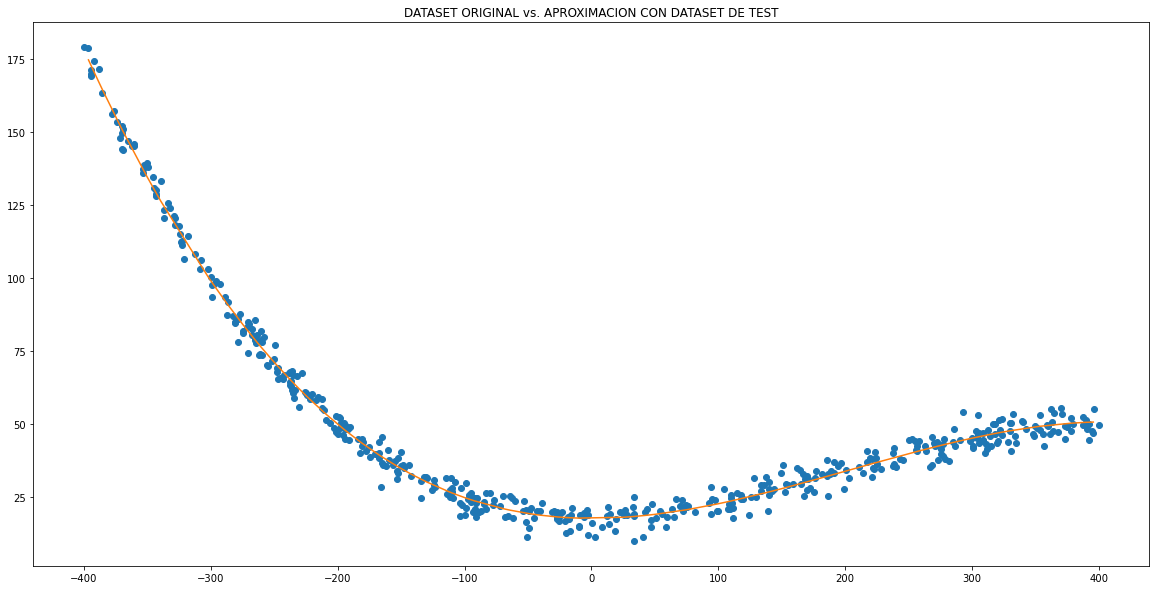

In [33]:
x3_test = x_test.copy()
x3_test = x3_test[np.argsort(x_test)]
x_n3_test = dataset_manipulation(x_test, polinomy_grade=3, bias=True)

plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
plt.gca().set_title('DATASET ORIGINAL vs. APROXIMACION CON DATASET DE TEST')
plt.plot(dataset.x, dataset.y, 'o')
plt.plot(x3_test, np.sum(model_n3[n3_min_idx].T*x_n3_test, axis=1)[np.argsort(x_test)], '-')

### 4-Mini-Batch Gradient Descent

In [171]:
def mini_batch_gradient_descent(x_train_mb, y_train_mb, x_test_mb, y_test_mb, lr=0.1, amt_epochs=100):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = 5
    n = x_train_mb.shape[0]
    m = x_train_mb.shape[1]

    # initialize random weights
    w = np.random.randn(m).reshape(m, 1)
    
    mse_train = []
    mse_val = []
    for epoch in range(amt_epochs):
        idx = np.random.permutation(x_train_mb.shape[0])
        x_train_mb = x_train_mb[idx]
        y_train_mb = y_train_mb[idx]

        batch_size = int(len(x_train_mb) / b)
        for i in range(0, len(x_train_mb), batch_size):
            end = i + batch_size if i + batch_size <= len(x_train_mb) else len(x_train_mb)
            batch_x = x_train_mb[i: end]
            batch_y = y_train_mb[i: end]
            
            batch_y = batch_y.reshape(-1,1) #Con esta linea corrijo el error que tenia debido a las dimensiones de las matrices.
            
            prediction = np.matmul(batch_x, w)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(error * batch_x, axis=0)
            grad_mul = -2/batch_size * grad_sum  # 1xm
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

            w = w - (lr * gradient)
        
        mse_train.append(mse(y_train_mb.reshape(-1,1), np.matmul(x_train_mb, w)))
        mse_val.append(mse(y_test_mb.reshape(-1,1), np.matmul(x_test_mb, w)))
    
    plt.figure(figsize=(20,10))
    plt.subplot(1, 1, 1)
    #plt.gca().set_title('Error')
    plt.plot(e, mse_train, '--')
    plt.plot(e, mse_val, '-')
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(['Error de entrenamiento', 'Error de validacion'])
    
    return w, mse_train, mse_val

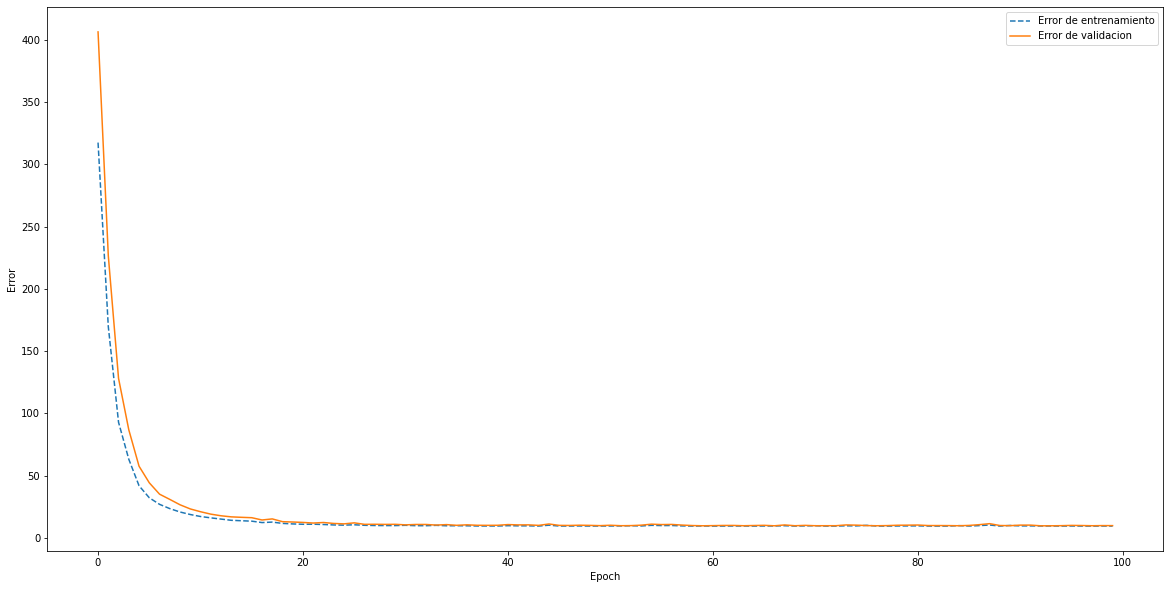

In [172]:
dataset_mb=Data(r'clase_8_dataset.csv')
x_train_mb, x_test_mb, y_train_mb, y_test_mb = dataset_mb.split(0.8)
x_n3_mb = dataset_manipulation(x_train_mb/np.max(x_train_mb), polinomy_grade=3, bias=True)   

x_n3_test_mb = dataset_manipulation(x_test_mb/np.max(x_train_mb), polinomy_grade=3, bias=True)

amt_epochs=100

w, mse_train, mse_val = mini_batch_gradient_descent(x_n3_mb, y_train_mb, x_n3_test, y_test, lr=0.5, amt_epochs=100)


#

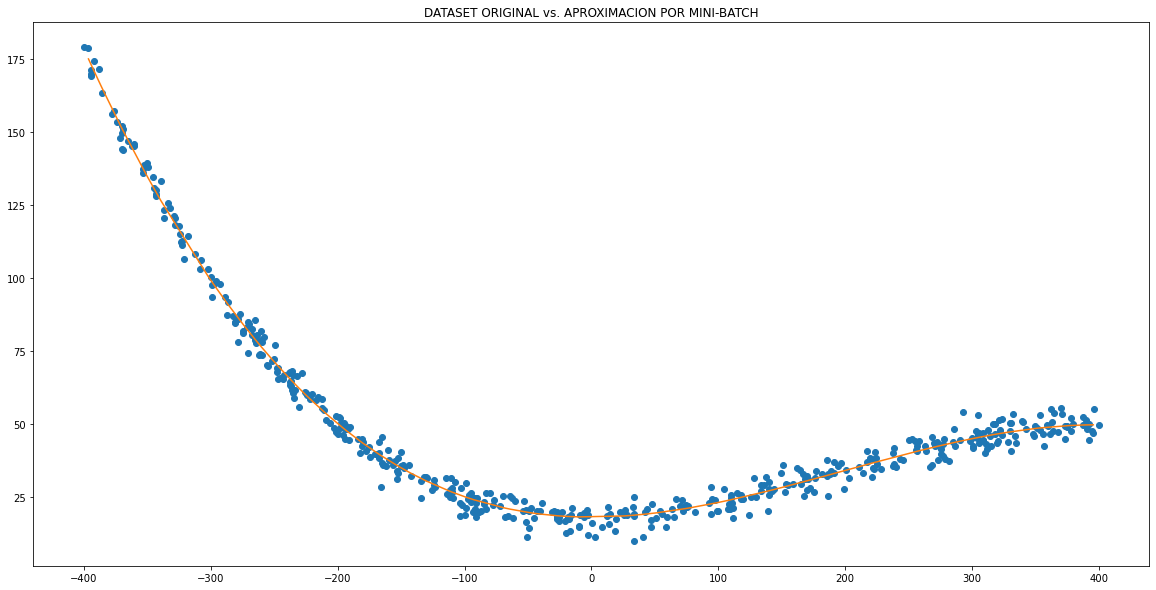

In [193]:
x3_mb_test = x_test.copy()
x3_mb_test = x3_mb_test[np.argsort(x_test)]
x_n3_testmb = dataset_manipulation(x_test[np.argsort(x_test)]/np.max(x_train), polinomy_grade=3, bias=True)

plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
plt.gca().set_title('DATASET ORIGINAL vs. APROXIMACION POR MINI-BATCH')
plt.plot(dataset_mb.x, dataset_mb.y, 'o')
plt.plot(x3_mb_test, np.sum(np.dot(x_n3_testmb,w), axis=1), '-')

**Comparacion de Modelos**

In [174]:
pd.DataFrame(data=[[np.float16(model_n3[n3_min_idx,:]), mse_list_n3[n3_min_idx], mse(y_test, y_hat_n3)],\
                   [np.float16(w.reshape(1,-1)), mse_train[amt_epochs-1], mse_val[amt_epochs-1]]],\
             index=["Normal Equation","MB Descent Gradient"], columns=["Modelo", "MSE_train", "MSE_test"])

,Modelo,MSE_train,MSE_test
Normal Equation,"[-1e-06, 0.0006037, -0.000622, 17.86]",7.386013,9.688234
MB Descent Gradient,"[[-64.25, 95.75, 0.0695, 18.28]]",9.374952,9.752936


**Conclusiones:** Podemos observar como el incremento del numero de epoch mejora hasta cierto punto el desempeño del modelo. Para esto fue importante ajustar el "learning rate".

### 5-Mini-Batch Gradient Descent with Ridge-Regularization

In [38]:
from sklearn.linear_model import Ridge
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

In [39]:
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    # Hacemos el fit del modelo
    ridgereg = Ridge(alpha=alpha, normalize=True)
    ridgereg.fit(data[predictors], data['y'])
    y_pred = ridgereg.predict(data[predictors])

    # Se agregar una utilidad para graficar (ver fuente original) donde se indica el alpha
    # a graficar (models_to_plot: diccionario con el orden del gráfico dentro del subplot)
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'], data['y'], '.')
        plt.plot(data['x'][np.argsort(data['x'])], y_pred[np.argsort(data['x'])])
        plt.title('Plot for alpha: %.3g' % alpha)

    # Calculamos el ECM y devolvemos el mísmo junto con el intercept y el resto de los parámetros del modelo.
    rss = sum((y_pred - data['y']) ** 2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

In [155]:
dataset_mb=Data(r'clase_8_dataset.csv')
x_train_mbr2, x_test_mbr2, y_train_mbr2, y_test_mbr2 = dataset_mb.split(0.8)

poly_data = dataset_manipulation(x_train_mbr2, polinomy_grade=3, bias=False)

# Creamos los column names para el dataframe (va a ser más fácil dar seguimiento luego)
colname = ['x']
for i in range(2, 4):
    colname.append('x_%d'%i)

colname.append('y')

# Creamos el dataframe
data = pd.DataFrame(np.column_stack([poly_data[:,2],poly_data[:,1],poly_data[:,0],y_train_mbr2]),columns=colname)

data.head()

,x,x_2,x_3,y
0,-258.353936,66746.756328,-1.724429e+07,79.862865
1,-61.900863,3831.716852,-2.371866e+05,18.037368
2,72.770065,5295.482377,3.853526e+05,21.769071
3,-265.547547,70515.499504,-1.872522e+07,79.506191
4,372.991818,139122.896376,5.189170e+07,44.879810


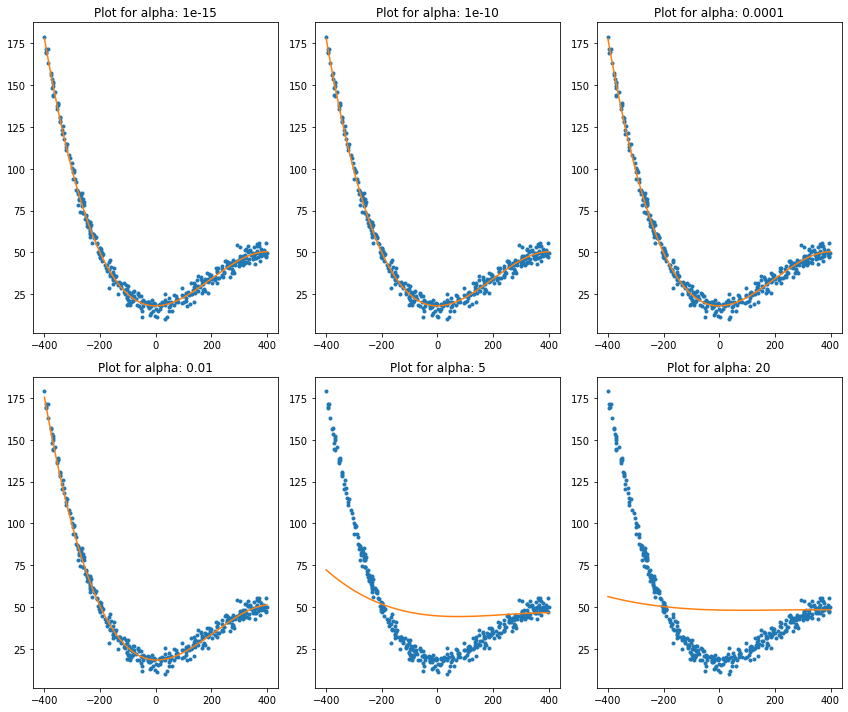

In [156]:
# Establecemos como features todas los órdenes del polinomio hasta el 15. Prueben con diferentes regresiones polinómicas para 
# ver el impacto en los coeficientes en función del alpha de regularización (lambda en la teoría)

predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,4)]) # Cambien el range para experimentar con diferentes polinomios

# Armamos un array con los distintos valores de lambda a probar
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

# Inicializamos el dataframe de parámetros como en el ejemplo anterior

col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,4)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-2:234, 5:235, 20:236}

for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

In [206]:
def MBGD_r2(x_train_mb, y_train_mb, x_test_mb, y_test_mb, lr=0.01, amt_epochs=100, lamb=0.1):
    """
    shapes:
        X_t = nxm
        y_t = nx1
        W = mx1
    """
    b = 5
    n = x_train_mb.shape[0]
    m = x_train_mb.shape[1]

    # initialize random weights
    w = np.random.randn(m).reshape(m, 1)
    
    mse_train = []
    mse_val = []
    for epoch in range(amt_epochs):
        idx = np.random.permutation(x_train_mb.shape[0])
        x_train_mb = x_train_mb[idx]
        y_train_mb = y_train_mb[idx]

        batch_size = int(len(x_train_mb) / b)
        c = 1 - ((lr*lamb)/batch_size)
        
        for i in range(0, len(x_train_mb), batch_size):
            end = i + batch_size if i + batch_size <= len(x_train_mb) else len(x_train_mb)
            batch_x = x_train_mb[i: end]
            batch_y = y_train_mb[i: end]
            
            batch_y = batch_y.reshape(-1,1) #Con esta linea corrijo el error que tenia debido a las dimensiones de las matrices.
            
            prediction = np.matmul(batch_x, w)  # nx1
            error = batch_y - prediction  # nx1

            grad_sum = np.sum(error * batch_x, axis=0)
            grad_mul = -2/batch_size * grad_sum  # 1xm
            gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1
             
            #w = (w*(1 - ((lr*lamb)/batch_size))) - gradient
            w = w*c-gradient
        mse_train.append(mse(y_train_mb.reshape(-1,1), np.matmul(x_train_mb, w)))
        mse_val.append(mse(y_test_mb.reshape(-1,1), np.matmul(x_test_mb, w)))
    
    plt.figure(figsize=(20,10))
    plt.subplot(1, 1, 1)
    #plt.gca().set_title('Error')
    plt.plot(e, mse_train, '--')
    plt.plot(e, mse_val, '-')
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(['Error de entrenamiento', 'Error de validacion'])        
    return w, mse_train, mse_val

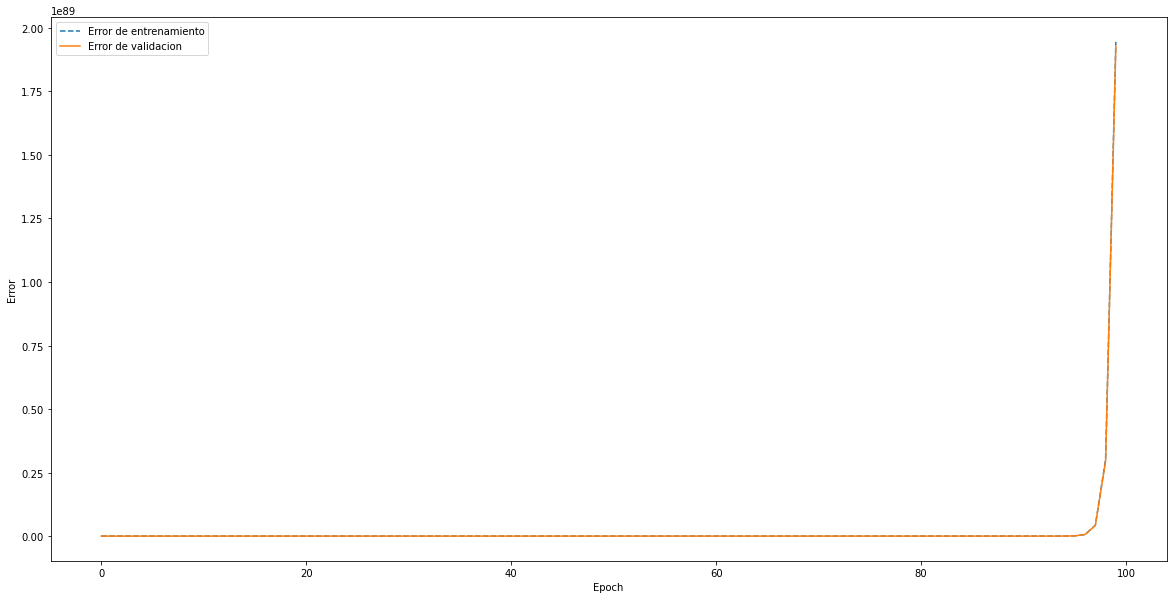

In [207]:
amt_epochs = 100
e = np.arange(amt_epochs)

#*******************************
dataset_mbridge=Data(r'clase_8_dataset.csv')
x_train_mbridge, x_test_mbridge, y_train_mbridge, y_test_mbridge = dataset_mbridge.split(0.8)
x_n3_mbridge = dataset_manipulation(x_train_mbridge/np.max(x_train_mbridge), polinomy_grade=3, bias=True)   

x_n3_test_mbridge = dataset_manipulation(x_test_mbridge/np.max(x_train_mbridge), polinomy_grade=3, bias=True)

wridge, mse_trainridge, mse_valridge = MBGD_r2(x_n3_mbridge, y_train_mbridge, x_n3_test_mbridge, y_test_mbridge, lr=0.001, amt_epochs=100, lamb = 10**(-15))



In [199]:
pd.DataFrame(data=[[np.float16(model_n3[n3_min_idx,:]), mse_list_n3[n3_min_idx], mse(y_test, y_hat_n3)],\
                   [np.float16(w.reshape(1,-1)), mse_train[amt_epochs-1], mse_val[amt_epochs-1]],\
                   [np.float16(wridge.reshape(1,-1)), mse_trainridge[amt_epochs-1], mse_valridge[amt_epochs-1]]],\
             index=["Normal Equation","MB Descent Gradient", "MBDG-Ridge"], columns=["Modelo", "MSE_train", "MSE_test"])

,Modelo,MSE_train,MSE_test
Normal Equation,"[-1e-06, 0.0006037, -0.000622, 17.86]",7.386013e+00,9.688234e+00
MB Descent Gradient,"[[-64.25, 95.75, 0.0695, 18.28]]",9.374952e+00,9.752936e+00
MBDG-Ridge,"[[inf, -inf, -inf, -inf]]",5.564239e+85,5.693709e+85


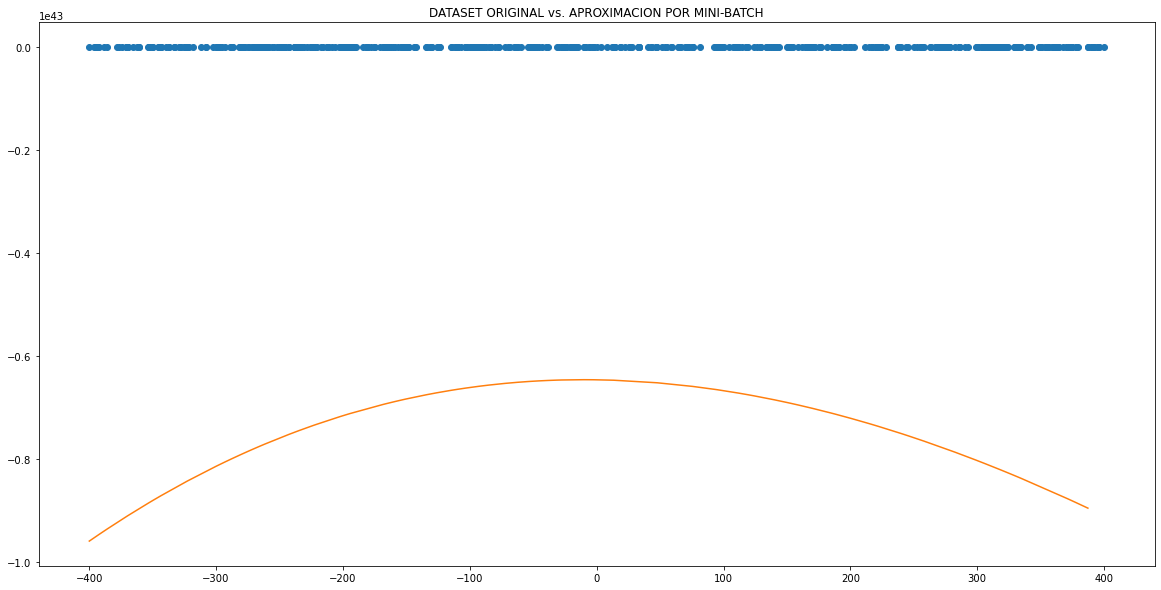

In [200]:
x3_mbridge_test = x_test_mbridge.copy()
x3_mbridge_test = x3_mbridge_test[np.argsort(x_test_mbridge)]
x_n3_testmbridge = dataset_manipulation(x_test_mbridge[np.argsort(x_test_mbridge)]/np.max(x_train_mbridge), polinomy_grade=3, bias=True)

plt.figure(figsize=(20,10))
plt.subplot(1, 1, 1)
plt.gca().set_title('DATASET ORIGINAL vs. APROXIMACION POR MINI-BATCH')
plt.plot(dataset_mbridge.x, dataset_mbridge.y, 'o')
plt.plot(x3_mbridge_test, np.sum(np.dot(x_n3_testmbridge,wridge), axis=1), '-')